# Merger models of blue supergiants 

Plots the period spacing and large frequency separation of merger models. 

by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Yale University, USA_ \
$^3$_Stellar Astrophysics Centre, Aarhus, Denmark_

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from scipy.signal import savgol_filter

from ipywidgets import interact, IntSlider

import seaborn as sns

import functools

import pickle

In [2]:
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse

In [3]:
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [4]:
# Set plotting style 
sns.set(style="ticks", palette="muted", 
        rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('thinfig')

In [5]:
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [6]:
from mesagrid import Track, Grid

In [7]:
def load_history_extras(self, DF_):
    v_hr = np.sqrt(np.diff(DF_['log_L'])**2 + np.diff(DF_['log_Teff'])**2) / np.diff(DF_['star_age'])
    DF_['v_hr'] = np.concatenate(([np.nan], v_hr))
    
    v_dnu = np.diff(DF_['delta_nu']) / np.diff(DF_['star_age'])
    DF_['v_dnu'] = np.concatenate(([np.nan], v_dnu))
    
    v_30_dnu = np.diff(30*DF_['delta_nu']) / np.diff(DF_['star_age'])
    DF_['v_30_dnu'] = np.concatenate(([np.nan], v_30_dnu))
    
    
    # period spacing 
    delta_Pg_dict = {} 
    gyres = self.get_gyres()
    for i, gyre in enumerate(gyres):
        profile_number = self.index.profile_number[i]
        model_number = self.index.loc[self.index.profile_number == profile_number, 'model_number'].values[0]
        N  = gyre.N
        x  = gyre.r
        m  = gyre.m
        delta_Pg = 2*np.pi**2/np.sqrt(2)/ sp.integrate.trapz(N[N>0]/x[N>0], x[N>0])
        delta_Pg_dict[model_number] = delta_Pg
    DF_['delta_Pg'] = DF_['model_number'].map(delta_Pg_dict)
    
    self._gyres = None
    self._profiles = None
    
    
    return DF_

In [8]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L', 'center_h1', 'center_he4', 'delta_nu']

In [9]:
grid_dirs = ["work/grid_normal", "work/grid_merge"]
grid_normal, grid_merger = [Grid(dir, load_history_extras=load_history_extras,
                                usecols_history=usecols_history)
                            for dir in grid_dirs]

In [10]:
import pickle
with open('work/pkl/grid_normal-freq_change.pkl', 'rb') as f:
    grid_normal = pickle.load(f)

with open('work/pkl/grid_merger-freq_change.pkl', 'rb') as f:
    grid_merger = pickle.load(f)

In [11]:
grid_normal

Grid with 22 tracks
Columns: M, os, Z, Track
M     [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....
os                                         [0.335, 0.7]
Z                                                [0.02]
dtype: object

In [12]:
grid_merger

Grid with 19 tracks
Columns: M, mc, mg, Ye, Z, Track
M     [14.0, 15.0, 16.0, 10.0, 11.0, 12.0, 13.0, 17....
mc                                    [0.3, 0.25, 0.35]
mg                                     [0.3, 0.0, 0.15]
Ye                                   [0.28, 0.31, 0.34]
Z                                                [0.02]
dtype: object

In [13]:
grid_ = grid_normal.df[(grid_normal.df['os'] == 0.7) & (grid_normal.df['Z'] == 0.02)]
c = np.nanmin(grid_.loc[grid_['M'].idxmin()]['Track'].history.v_hr)
c

3.985362587216144e-09

In [14]:
def get_data_points(DF_, label):
    if DF_.center_he4[0] > 0.5: # merger
        DF_ = DF_[DF_.center_he4 < 0.95]
    else:
        DF_ = DF_[DF_.center_h1 <= 0.7]
    
    if DF_.empty:
        return []
        
    DF_ = DF_[10**DF_.log_Teff <= 20000]
    DF_ = DF_[10**DF_.log_Teff >= 10000]
    
    if DF_.empty:
        return []
    
    if label == 'H Shell':
        DF_ = DF_[DF_.center_h1 <= 0.0001]
    elif label == 'H Core':
        DF_ = DF_[DF_.center_h1 >= 0.01]
    
    if DF_.empty:
        return []
    
    if label == 'Merger' or label == 'H Core':
        DF_ = DF_[DF_.v_hr/c < 100]
    
    if DF_.empty:
        return []
    
    return DF_

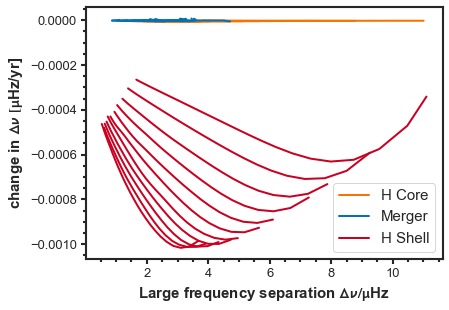

In [15]:
colors = [orange, blue, red]
labels = ['H Core', 'Merger', 'H Shell']

plt.figure(figsize=(8*(4/5),6.5*(4/5)*(7/8)))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_nu'], DF_['v_dnu'], c=color, label=label if first else None, lw=2)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df
grids = [grid_Hcore, grid_merg, grid_Hshell]

for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)

plt.legend()
plt.xlabel(r'Large frequency separation $\mathbf{\Delta\nu/\mu}$Hz')
plt.ylabel(r'change in $\mathbf{\Delta\nu~[\mu}$Hz/yr]');

In [16]:
from astropy import units as u

def frequency_resolution(t):
    return (1 / (t * u.year)).to(u.microhertz).value

In [17]:
grid.iloc[0].Track.history

,model_number,star_age,log_Teff,log_L,center_h1,center_he4,delta_nu,v_hr,v_dnu,v_30_dnu,delta_Pg
0,1,3.162278e+02,4.400315,3.748195,0.699791,0.279910,49.735196,NaN,NaN,NaN,13069.139206
1,2,6.957011e+02,4.397065,3.737970,0.699802,0.279921,49.498904,2.827393e-05,-6.226864e-04,-1.868059e-02,13579.461506
2,3,1.151069e+03,4.392679,3.724297,0.699814,0.279935,49.170751,3.153383e-05,-7.206313e-04,-2.161894e-02,14121.644213
3,4,1.697511e+03,4.387947,3.709666,0.699815,0.279945,48.809753,2.814026e-05,-6.606343e-04,-1.981903e-02,14596.502757
4,5,2.353241e+03,4.383382,3.695789,0.699809,0.279951,48.444866,2.227870e-05,-5.564592e-04,-1.669378e-02,14986.488037
...,...,...,...,...,...,...,...,...,...,...,...
420,421,2.644996e+07,3.585020,4.276610,0.000000,0.126376,0.100049,4.706346e-08,-1.442059e-08,-4.326178e-07,1122.189248
421,422,2.646309e+07,3.584895,4.277263,0.000000,0.118984,0.099844,5.066293e-08,-1.560989e-08,-4.682966e-07,1112.167314
422,423,2.647568e+07,3.584764,4.277923,0.000000,0.112089,0.099633,5.341898e-08,-1.670834e-08,-5.012502e-07,1108.590338
423,424,2.648779e+07,3.584627,4.278598,0.000000,0.105588,0.099416,5.684435e-08,-1.798622e-08,-5.395865e-07,1106.452652


In [18]:
import matplotlib.ticker as ticker

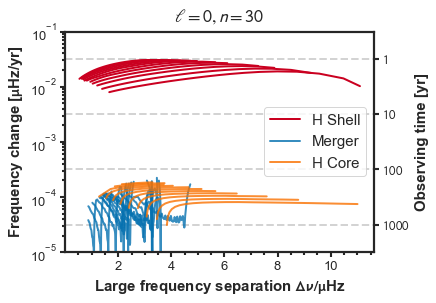

In [19]:
plt.figure(figsize=(8*(4/5),6.5*(4/5)*(7/8)))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_nu'], np.abs(DF_['v_30_dnu']), c=color, label=label if first else None, lw=2,
                    alpha=1 if label=='H Shell' else 0.8)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df #.filter({'Z': 0.02, 'mc':0.3, 'mg': 0, 'Ye': 0.28})
grids = [grid_Hshell, grid_merg, grid_Hcore]
colors = [red, blue, orange]
labels = ['H Shell', 'Merger', 'H Core']

for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)
plt.axhline(frequency_resolution(1), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(100), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(1000), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10000), ls='--', c='lightgray', zorder=-999)

plt.legend()
plt.semilogy()
plt.xlabel(r'Large frequency separation $\mathbf{\Delta\nu/\mu}$Hz')
plt.ylabel(r'Frequency change [$\mathbf{\mu}$Hz/yr]'); #$\mathbf{\Delta\nu~[\mu}$Hz/yr]');
plt.title('$\ell=0, n=30$')
plt.ylim([1e-5, 1e-1])

ax1 = plt.gca()
ax2 = ax1.twinx()
times = [1, 10, 100, 1000, 10000, 100000]
freq_ress = [frequency_resolution(t) for t in times]
ax2.set_yscale('log')
ax2.set_yticks(freq_ress)
ax2.set_yticklabels(['$10^{{{:.0f}}}$'.format(np.log10(t)) if t > 1000 else str(r'$'+str(t)+r'$') for t in times])
ax2.tick_params(axis='y', which='minor', left=False, right=False)

ax2.set_ylabel('Observing time [yr]')
ax2.set_ylim(ax1.get_ylim());

plt.tight_layout()
#plt.savefig('figs/freq-change.pdf')

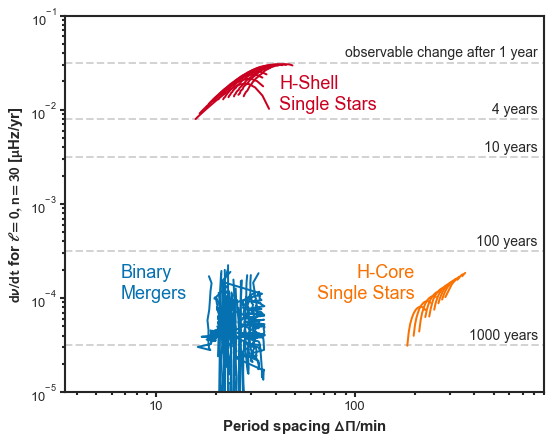

In [20]:
plt.figure(figsize=(8,6.5))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_Pg']/60, np.abs(DF_['v_30_dnu']), c=color, label=label if first else None, lw=2)#,
                    #alpha=1 if label=='H Shell' else 0.8)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df 
grids = [grid_Hshell, grid_merg, grid_Hcore]
colors = [red, blue, orange]
labels = ['H Shell', 'Merger', 'H Core']
for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)

plt.axhline(frequency_resolution(1), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(4), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(100), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(1000), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10000), ls='--', c='lightgray', zorder=-999)
plt.text(5*10**4/60, frequency_resolution(1)*1.15, 'observable change after 1 year', ha='right', size=14)
plt.text(5*10**4/60, frequency_resolution(4)*1.15, '4 years', ha='right', size=14)
plt.text(5*10**4/60, frequency_resolution(10)*1.15, '10 years', ha='right', size=14)
plt.text(5*10**4/60, frequency_resolution(100)*1.15, '100 years', ha='right', size=14)
plt.text(5*10**4/60, frequency_resolution(1000)*1.15, '1000 years', ha='right', size=14)

plt.text(2.5*10**3/60, 10**-2, 'H-Shell\nSingle Stars', c=red, size=18)
plt.text(1.2*10**4/60, 10**-4, 'H-Core\nSingle Stars', c=orange, size=18, ha='right')
plt.text(4*10**2/60, 10**-4, 'Binary\nMergers', c=blue, size=18)

plt.ylim([1e-5, 1e-1])
plt.xlim([3.5, 900])
plt.semilogy()
plt.semilogx()
plt.gca().set_xticks([10, 100])
plt.gca().set_xticklabels(['10', '100'])
plt.xlabel(r'Period spacing $\mathbf{\Delta\Pi/}$min')
plt.ylabel(r'$\mathbf{d\nu/dt}$ for $\mathbf{\ell=0, n=30}$ [$\mathbf{\mu}$Hz/yr]'); #$\mathbf{\Delta\nu~[\mu}$Hz/yr]');

plt.tight_layout()
#plt.savefig('figs/freq-change.pdf')

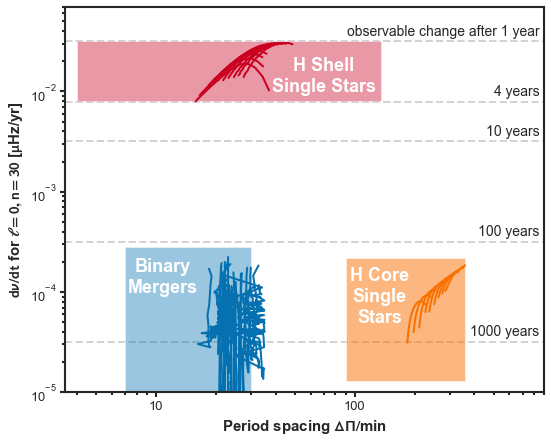

In [21]:
plt.figure(figsize=(8,6.5))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_Pg']/60, np.abs(DF_['v_30_dnu']), c=color, label=label if first else None, lw=2)#,
                    #alpha=1 if label=='H Shell' else 0.8)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df
grids = [grid_Hshell, grid_merg, grid_Hcore]
colors = [red, blue, orange]
labels = ['H Shell', 'Merger', 'H Core']
for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)

plt.axhline(frequency_resolution(1), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(4), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(100), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(1000), ls='--', c='lightgray', zorder=-999)
plt.text(5.1*10**4/60, frequency_resolution(1)*1.15, 'observable change after 1 year', ha='right', size=14)
plt.text(5.1*10**4/60, frequency_resolution(4)*1.15, '4 years', ha='right', size=14)
plt.text(5.1*10**4/60, frequency_resolution(10)*1.15, '10 years', ha='right', size=14)
plt.text(5.1*10**4/60, frequency_resolution(100)*1.15, '100 years', ha='right', size=14)
plt.text(5.1*10**4/60, frequency_resolution(1000)*1.15, '1000 years', ha='right', size=14)

plt.gca().add_patch(mpl.patches.Rectangle((7, 1e-5), 30-7, 2.8*1e-4 - 1e-5, color=blue, alpha=0.4, ec=None))
plt.gca().add_patch(mpl.patches.Rectangle((90, 1.3e-5), 360-90, 2.2*1e-4 - 1.3e-5, color=orange, alpha=0.5, ec=None))
plt.gca().add_patch(mpl.patches.Rectangle((4, 0.8e-2), 135-4, 3.2e-2 - 0.8e-2, color=red, alpha=0.4, ec=None))
plt.text(4.2*10**3/60, 10**-2, 'H Shell\nSingle Stars', c='white', size=18, weight='bold', ha='center')
plt.text(0.8*10**4/60, 0.5*10**-4, 'H Core\nSingle\nStars', c='white', size=18, weight='bold', ha='center')
plt.text(6.5*10**2/60, 10**-4, 'Binary\nMergers', c='white', size=18, weight='bold', ha='center')

plt.ylim([1e-5, 7e-2])
plt.xlim([3.5, 900])
plt.semilogy()
plt.semilogx()
plt.gca().set_xticks([10, 100])
plt.gca().set_xticklabels(['10', '100'])
plt.xlabel(r'Period spacing $\mathbf{\Delta\Pi/}$min')
plt.ylabel(r'$\mathbf{d\nu/dt}$ for $\mathbf{\ell=0, n=30}$ [$\mathbf{\mu}$Hz/yr]'); #$\mathbf{\Delta\nu~[\mu}$Hz/yr]');

plt.tight_layout()
#plt.savefig('figs/freq-change.pdf')

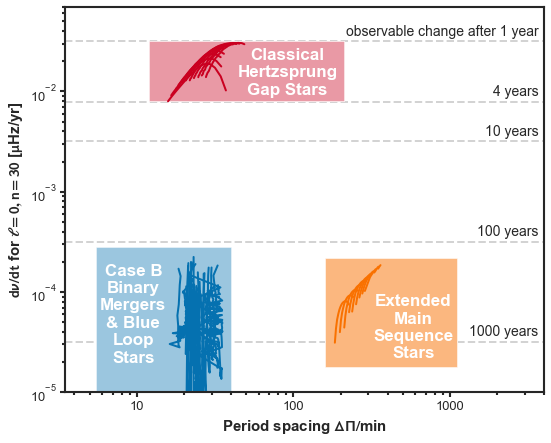

In [22]:
plt.figure(figsize=(8,6.5))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_Pg']/60, np.abs(DF_['v_30_dnu']), c=color, label=label if first else None, lw=2)#,
                    #alpha=1 if label=='H Shell' else 0.8)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df 
grids = [grid_Hshell, grid_merg, grid_Hcore]
colors = [red, blue, orange]
labels = ['H Shell', 'Merger', 'H Core']
for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)

plt.axhline(frequency_resolution(1), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(4), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(100), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(1000), ls='--', c='lightgray', zorder=-999)
plt.text(22*10**4/60, frequency_resolution(1)*1.15, 'observable change after 1 year', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(4)*1.15, '4 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(10)*1.15, '10 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(100)*1.15, '100 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(1000)*1.15, '1000 years', ha='right', size=14)

plt.gca().add_patch(mpl.patches.Rectangle((5.5, 1e-5), 40-5.5, 2.8*1e-4 - 1e-5, color='w', alpha=1, ec=None, zorder=-99))
plt.gca().add_patch(mpl.patches.Rectangle((160, 1.8e-5), 1100-160, 2.2*1e-4 - 1.8e-5, color='w', alpha=1, ec=None, zorder=-99))
plt.gca().add_patch(mpl.patches.Rectangle((12, 0.8e-2), 210-12, 3.2e-2 - 0.8e-2, color='w', alpha=1, ec=None, zorder=-99))

plt.gca().add_patch(mpl.patches.Rectangle((5.5, 1e-5), 40-5.5, 2.8*1e-4 - 1e-5, color=blue, alpha=0.4, ec=None))
plt.gca().add_patch(mpl.patches.Rectangle((160, 1.8e-5), 1100-160, 2.2*1e-4 - 1.8e-5, color=orange, alpha=0.5, ec=None))
plt.gca().add_patch(mpl.patches.Rectangle((12, 0.8e-2), 210-12, 3.2e-2 - 0.8e-2, color=red, alpha=0.4, ec=None))
plt.text(5.5*10**3/60, 0.94*10**-2, 'Classical\nHertzsprung\nGap Stars', c='white', size=17, weight='bold', ha='center')
plt.text(3.5*10**4/60, 0.22*10**-4, 'Extended\nMain\nSequence\nStars', c='white', size=17, weight='bold', ha='center')
plt.text(5.7*10**2/60, 2*10**-5, 'Case B\nBinary\nMergers\n& Blue\nLoop\nStars', c='white', size=17, weight='bold', ha='center')

plt.ylim([1e-5, 7e-2])
plt.xlim([3.5, 4000])
plt.semilogy()
plt.semilogx()
#plt.gca().set_xticks([10, 100])
plt.gca().set_xticks([10, 100, 1000])
#plt.gca().set_xticklabels(['10', '100'])
plt.gca().set_xticklabels(['10', '100', '1000'])
plt.xlabel(r'Period spacing $\mathbf{\Delta\Pi/}$min')
plt.ylabel(r'$\mathbf{d\nu/dt}$ for $\mathbf{\ell=0, n=30}$ [$\mathbf{\mu}$Hz/yr]'); #$\mathbf{\Delta\nu~[\mu}$Hz/yr]');

plt.tight_layout()
#plt.savefig('figs/freq-change.pdf')

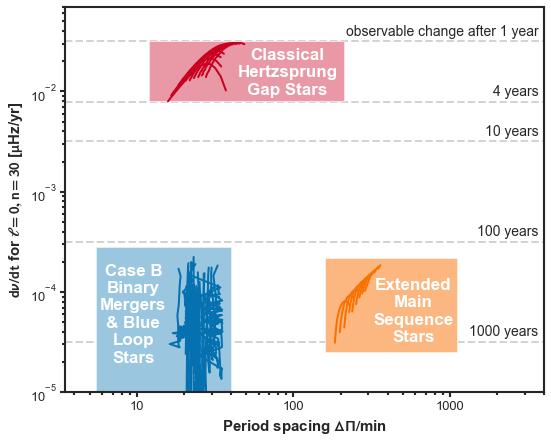

In [23]:
plt.figure(figsize=(8,6.5))
plt.gca().set_rasterization_zorder(-1)

def plot_points(grid, label, color):
    first = True
    for row in grid.itertuples():
        DF_ = get_data_points(row.Track.history, label=label)
        if len(DF_) > 0:
            plt.plot(DF_['delta_Pg']/60, np.abs(DF_['v_30_dnu']), c=color, label=label if first else None, lw=2)#,
                    #alpha=1 if label=='H Shell' else 0.8)
            first = False

grid_Hcore  = grid_normal.filter({'os': 0.7, 'Z': 0.02})
grid_Hshell = grid_normal.filter({'os': 0.335, 'Z': 0.02})
grid_merg   = grid_merger.df #.filter({'Z': 0.02, 'mc':0.3, 'mg': 0, 'Ye': 0.28})
grids = [grid_Hshell, grid_merg, grid_Hcore]
colors = [red, blue, orange]
labels = ['H Shell', 'Merger', 'H Core']
for grid, label, color in zip(grids, labels, colors):
    plot_points(grid, label, color)

plt.axhline(frequency_resolution(1), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(10), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(4), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(100), ls='--', c='lightgray', zorder=-999)
plt.axhline(frequency_resolution(1000), ls='--', c='lightgray', zorder=-999)
plt.text(22*10**4/60, frequency_resolution(1)*1.15, 'observable change after 1 year', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(4)*1.15, '4 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(10)*1.15, '10 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(100)*1.15, '100 years', ha='right', size=14)
plt.text(22*10**4/60, frequency_resolution(1000)*1.15, '1000 years', ha='right', size=14)

def add_rectangle(x1, y1, x2, y2, color, alpha, ec=None, zorder=-99):
    plt.gca().add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, color='w', ec='w', zorder=zorder))
    plt.gca().add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, color=color, alpha=alpha, ec=ec, zorder=zorder))
add_rectangle(5.5, 1e-5,     40, 2.8e-4, blue,   0.4)
add_rectangle(160, 2.5e-5, 1100, 2.2e-4, orange, 0.5)
add_rectangle(12,  0.8e-2,  210, 3.2e-2, red,    0.4)

plt.text(5.5*10**3/60, 0.94*10**-2, 'Classical\nHertzsprung\nGap Stars', c='white', size=17, weight='bold', ha='center')
plt.text(3.5*10**4/60, 0.32*10**-4, 'Extended\nMain\nSequence\nStars', c='white', size=17, weight='bold', ha='center')
plt.text(5.7*10**2/60, 2*10**-5, 'Case B\nBinary\nMergers\n& Blue\nLoop\nStars', c='white', size=17, weight='bold', ha='center')

plt.ylim([1e-5, 7e-2])
plt.xlim([3.5, 4000])
plt.semilogy()
plt.semilogx()
#plt.gca().set_xticks([10, 100])
plt.gca().set_xticks([10, 100, 1000])
#plt.gca().set_xticklabels(['10', '100'])
plt.gca().set_xticklabels(['10', '100', '1000'])
plt.xlabel(r'Period spacing $\mathbf{\Delta\Pi/}$min')
plt.ylabel(r'$\mathbf{d\nu/dt}$ for $\mathbf{\ell=0, n=30}$ [$\mathbf{\mu}$Hz/yr]'); #$\mathbf{\Delta\nu~[\mu}$Hz/yr]');

plt.tight_layout()
plt.savefig('figs/freq-change.pdf')

In [24]:
import pickle
with open('work/pkl/grid_normal-freq_change.pkl', 'wb') as f:
    pickle.dump(grid_normal, f)
with open('work/pkl/grid_merger-freq_change.pkl', 'wb') as f:
    pickle.dump(grid_merger, f)